
# What you will accomplish

In this guide, you will:

    - Build, train, and tune a model using script mode
    - Detect bias in ML models and understand model predictions
    - Deploy the trained model to a real-time inference endpoint for testing
    - Evaluate the model by generating sample predictions and understanding feature impact



#### Bio: Jane Sassy, Data Scientist
#### Location: Bellevue, WA

Jane, is a data scientist working on training a binary classier model on insurance claims that predicts if the user could be fraudulent or not. She got the dataset from her companies data source and now ready to begin her ML life cycle.


- Jane first uses Studios IDE with some python libraries to explore the dataset and find some key characteristics that she can then use to engineer some features ( Assumption - This task has been completed before hand)

- Once she has done that, she decides to train XGboost model and starts training a base line model. Below example shows how to start training some base line models and do some experiemntation with various parameters using `SM Hyperparameter optimization`

- Before making the model final, she wants to check if the mode might have underling biased that could cause model to be impartial against certain facets like gender, race etc using ` SM Clarify Bias Reports`

- She also realizes that she needs to have an explainability around her model for why did model predict something, what causes model to make certain predictions? using `SM Explainability Reports`

- After the bais and explainability checks, she gets ready to deploy the model on a staging env using `SM Endpoints`

- She finally do some test inference calls to understand how the model is performing on some new unseen dataset.

- Once she is done with her tests she terminates her endpoint, and terminate the apps from her profile.

- 6 months later bob sees a deprecation in the performance of the deployed model which leads him in believing that the model might need to go through a re-training procedure. Thanks to `SM pipeline` he can retrain the whole model on a new data just from a click of a button reducing the model retraining cycle as well as increasing the reproducibiltiy of the past experiments.



# Step 2: Set up a SageMaker Studio notebook ( library installation & variable settings)

In [2]:
%pip install -q  xgboost==1.3.1 pandas==1.0.5

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.59
    Uninstalling botocore-1.27.59:
      Successfully uninstalled botocore-1.27.59
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.69 requires botocore==1.29.69, but you have botocore 1.29.84 which is incompatible.
awscli 1.27.69 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.27.69 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.29.84 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Setting SageMaker variables
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "fraud-detect-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")
read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 


# Setting S3 location for read and write operations
train_data_key = f"{read_prefix}/train.csv"
test_data_key = f"{read_prefix}/test.csv"
validation_data_key = f"{read_prefix}/validation.csv"
model_key = f"{write_prefix}/model"
output_key = f"{write_prefix}/output"


train_data_uri = f"s3://{read_bucket}/{train_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
model_uri = f"s3://{write_bucket}/{model_key}"
output_uri = f"s3://{write_bucket}/{output_key}"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/explainability"

In [6]:
tuning_job_name_prefix = "xgbtune" 
training_job_name_prefix = "xgbtrain"

xgb_model_name = "fraud-detect-xgb-model"
endpoint_name_prefix = "xgb-fraud-model-dev"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"

# Step 3: Launch hyperparameter tuning jobs in script mode using SageMaker Hyperparameter tuning jobs


In [7]:
%%writefile xgboost_train.py

import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=100)
    parser.add_argument("--max_depth", type=int, default=3)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.9)
    parser.add_argument("--colsample_bytree", type=float, default=0.8)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("fraud", axis=1)
    label_train = pd.DataFrame(data_train["fraud"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("fraud", axis=1)
    label_validation = pd.DataFrame(data_validation["fraud"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)

    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)

Overwriting xgboost_train.py


In [8]:
# SageMaker estimator

# Set static hyperparameters that will not be tuned
static_hyperparams = {  
                        "eval_metric" : "auc",
                        "objective": "binary:logistic",
                        "num_round": "5"
                      }

xgb_estimator = XGBoost(
                        entry_point="xgboost_train.py",
                        output_path=estimator_output_uri,
                        code_location=estimator_output_uri,
                        hyperparameters=static_hyperparams,
                        role=sagemaker_role,
                        instance_count=train_instance_count,
                        instance_type=train_instance_type,
                        framework_version="1.3-1",
                        base_job_name=training_job_name_prefix
                    )

In [9]:
# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "subsample": ContinuousParameter(0.7, 0.95),
    "colsample_bytree": ContinuousParameter(0.7, 0.95),
    "max_depth": IntegerParameter(1, 5)
}

In [10]:
objective_metric_name = "validation:auc"

# Setting up tuner object
tuner_config_dict = {
                     "estimator" : xgb_estimator,
                     "max_jobs" : 5,
                     "max_parallel_jobs" : 2,
                     "objective_metric_name" : objective_metric_name,
                     "hyperparameter_ranges" : hyperparameter_ranges,
                     "base_tuning_job_name" : tuning_job_name_prefix,
                     "strategy" : "Random"
                    }
tuner = HyperparameterTuner(**tuner_config_dict)

In [46]:
! aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic_automobile_claims/train.csv  s3://sagemaker-us-east-1-539179515961//synthetic_automobile_claims/train.csv

copy: s3://sagemaker-sample-files/datasets/tabular/synthetic_automobile_claims/train.csv to s3://sagemaker-us-east-1-539179515961//synthetic_automobile_claims/train.csv


In [45]:
"s3://{}/{}".format(read_bucket, train_data_key)

's3://sagemaker-sample-files/datasets/tabular/synthetic_automobile_claims/train.csv'

#### [Note 1]: Below cell ⬇️ will take about 7 mins to run as it tries to tune multiple parameters ( each dot indicates running state and ! indicates completion of the job)

#### [Note 2] You can head over to Sagemaker Console -> Hyperparameter tuning jobs to view the progress of the launched tuning jobs

In [11]:
# Setting the input channels for tuning job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )

tuner.fit(inputs={"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................!
!


In [12]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner[df_tuner["FinalObjectiveValue"]>-float('inf')].sort_values("FinalObjectiveValue", ascending=False)
df_tuner

,colsample_bytree,eta,max_depth,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.879236,0.077760,3.0,0.844381,xgbtune-230305-2121-005-a6359e56,Completed,0.69,2023-03-05 21:25:23+00:00,2023-03-05 21:26:01+00:00,38.0
4,0.765214,0.812848,4.0,0.856140,xgbtune-230305-2121-001-0c270f82,Completed,0.68,2023-03-05 21:22:35+00:00,2023-03-05 21:24:13+00:00,98.0
1,0.832288,0.412008,2.0,0.824303,xgbtune-230305-2121-004-bb3be393,Completed,0.67,2023-03-05 21:24:43+00:00,2023-03-05 21:25:15+00:00,32.0
3,0.865447,0.457186,1.0,0.902524,xgbtune-230305-2121-002-a3df569b,Completed,0.62,2023-03-05 21:22:41+00:00,2023-03-05 21:24:19+00:00,98.0
2,0.762691,0.111771,1.0,0.784966,xgbtune-230305-2121-003-e97d0dd1,Completed,0.56,2023-03-05 21:24:36+00:00,2023-03-05 21:25:13+00:00,37.0


### UI to Check: 📺
    - Experiments -> Hyperparameter Tuning Job / SM Hyperparameter Training Console


# Step 4: Check model for biases and explain model predictions using SageMaker Clarify


In [13]:
tuner_job_info = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

model_matches = sagemaker_client.list_models(NameContains=xgb_model_name)["Models"]

if not model_matches:
    _ = sess.create_model_from_job(
            name=xgb_model_name,
            training_job_name=tuner_job_info['BestTrainingJob']["TrainingJobName"],
            role=sagemaker_role,
            image_uri=tuner_job_info['TrainingJobDefinition']["AlgorithmSpecification"]["TrainingImage"]
            )
else:

    print(f"Model {xgb_model_name} already exists.")

Model fraud-detect-xgb-model already exists.


#### SM Clarify tries to detect if the data is statistically biased against females by checking if the target is skewed towards a value based on the customer gender

#### Next, configure the input dataset(`bias_data_config`), where to store the output(`s3_output_path`), the label column(`fraud`) targeted with a DataConfig object, specify information about your trained model with ModelConfig(`model_config`), and provide information about the formats of your predictions with ModelPredictedLabelConfig`predictions_config`). 

#### Bias config - Use `BiasConfig` to provide information on which columns contain the  facets (`sensitive groups, customer_gender_female`), what the sensitive features (`facet_values_or_threshold`) might be, and what the desirable outcomes are (`label_values_or_threshold`). 

[Note 1]: ETA:  This code takes approximately 12 minutes to complete.

[Note 2]: You can head over to Sagemaker Console -> Processing jobs to view the progress of the launched tuning jobs

In [15]:
train_df = pd.read_csv(train_data_uri)
train_df_cols = train_df.columns.to_list()

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=clarify_instance_count,
    instance_type=clarify_instance_type,
    sagemaker_session=sess,
)

# Data config
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=bias_report_output_uri,
    label="fraud",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Model config
model_config = sagemaker.clarify.ModelConfig(
    model_name=xgb_model_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

# Model predictions config to get binary labels from probabilities
predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

# Bias config
bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods=["CI"],
    post_training_methods=["DPPL"]
    )

clarify_bias_job_name = clarify_processor.latest_job.name

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['fraud', 'num_vehicles_involved', 'num_injuries', 'num_witnesses', 'police_report_available', 'injury_claim', 'vehicle_claim', 'total_claim_amount', 'incident_month', 'incident_day', 'incident_dow', 'incident_hour', 'customer_age', 'months_as_customer', 'num_claims_past_year', 'num_insurers_past_5_years', 'policy_deductable', 'policy_annual_premium', 'policy_liability', 'customer_education', 'auto_year', 'driver_relationship_other', 'driver_relationship_child', 'driver_relationship_spouse', 'driver_relationship_na', 'driver_relationship_self', 'incident_type_collision', 'incident_type_break-in', 'incident_type_theft', 'collision_type_rear', 'collision_type_side', 'collision_type_na', 'collision_type_front', 'incident_severity_totaled', 'incident_se

.........................................2023-03-05 21:52:02,763 logging.conf not found when configuring logging, using default logging configuration.
2023-03-05 21:52:02,764 Starting SageMaker Clarify Processing job
2023-03-05 21:52:02,764 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-03-05 21:52:02,764 Analysis result path: /opt/ml/processing/output
2023-03-05 21:52:02,764 This host is algo-1.
2023-03-05 21:52:02,764 This host is the leader.
2023-03-05 21:52:02,764 Number of hosts in the cluster is 1.
2023-03-05 21:52:03,007 Running Python / Pandas based analyzer.
2023-03-05 21:52:03,007 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-03-05 21:52:03,020 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:323: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2023-0

### UI to Check:  📺
    - Experiments -> Unassigned Runs / Processing Job UI to check logs 
    - Experiments -> Unassigned Runs-> Run-> Bias Reports

#### We can download this report and read through the observations made by clarify

In [17]:
# Copy bias report and view locally
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/bias/report.pdf ./clarify_bias_output.pdf

download: s3://sagemaker-us-east-1-539179515961/fraud-detect-demo/clarify-output/bias/report.pdf to ./clarify_bias_output.pdf


#### Explainability Report

[Note 1]: ETA: This code takes approximately 14 minutes to complete.

[Note 2]: You can head over to Sagemaker Console -> Processing jobs to view the progress of the launched tuning jobs


In [18]:
explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=explainability_report_output_uri,
    label="fraud",
    headers=train_df_cols,
    dataset_type="text/csv",
)

# Use mean of train dataset as baseline data point
shap_baseline = [list(train_df.drop(["fraud"], axis=1).mean())]

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=shap_baseline,
    num_samples=500,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['fraud', 'num_vehicles_involved', 'num_injuries', 'num_witnesses', 'police_report_available', 'injury_claim', 'vehicle_claim', 'total_claim_amount', 'incident_month', 'incident_day', 'incident_dow', 'incident_hour', 'customer_age', 'months_as_customer', 'num_claims_past_year', 'num_insurers_past_5_years', 'policy_deductable', 'policy_annual_premium', 'policy_liability', 'customer_education', 'auto_year', 'driver_relationship_other', 'driver_relationship_child', 'driver_relationship_spouse', 'driver_relationship_na', 'driver_relationship_self', 'incident_type_collision', 'incident_type_break-in', 'incident_type_theft', 'collision_type_rear', 'collision_type_side', 'collision_type_na', 'collision_type_front', 'incident_severity_totaled', 'incident_severity_major', 'incident_severity_minor', 'authorities_contacted_fire', 'authorities_contacted_none', 'authorities_contacted_police', 'authorities_contacted_ambu

........................................2023-03-05 22:09:46,598 logging.conf not found when configuring logging, using default logging configuration.
2023-03-05 22:09:46,599 Starting SageMaker Clarify Processing job
2023-03-05 22:09:46,600 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-03-05 22:09:46,600 Analysis result path: /opt/ml/processing/output
2023-03-05 22:09:46,600 This host is algo-1.
2023-03-05 22:09:46,600 This host is the leader.
2023-03-05 22:09:46,600 Number of hosts in the cluster is 1.
2023-03-05 22:09:46,838 Running Python / Pandas based analyzer.
2023-03-05 22:09:46,838 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-03-05 22:09:46,850 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:323: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2023-03

### UI to Check:  📺
    - Experiments -> Unassigned Runs / Processing Job UI to check logs 
    - Experiments -> Unassigned Runs-> Run-> Explainability

### Download explainability report

In [20]:
# Copy explainability report and view
!aws s3 cp s3://{write_bucket}/{write_prefix}/clarify-output/explainability/report.pdf ./clarify_explainability_output.pdf

download: s3://sagemaker-us-east-1-539179515961/fraud-detect-demo/clarify-output/explainability/report.pdf to ./clarify_explainability_output.pdf


Example number: 100


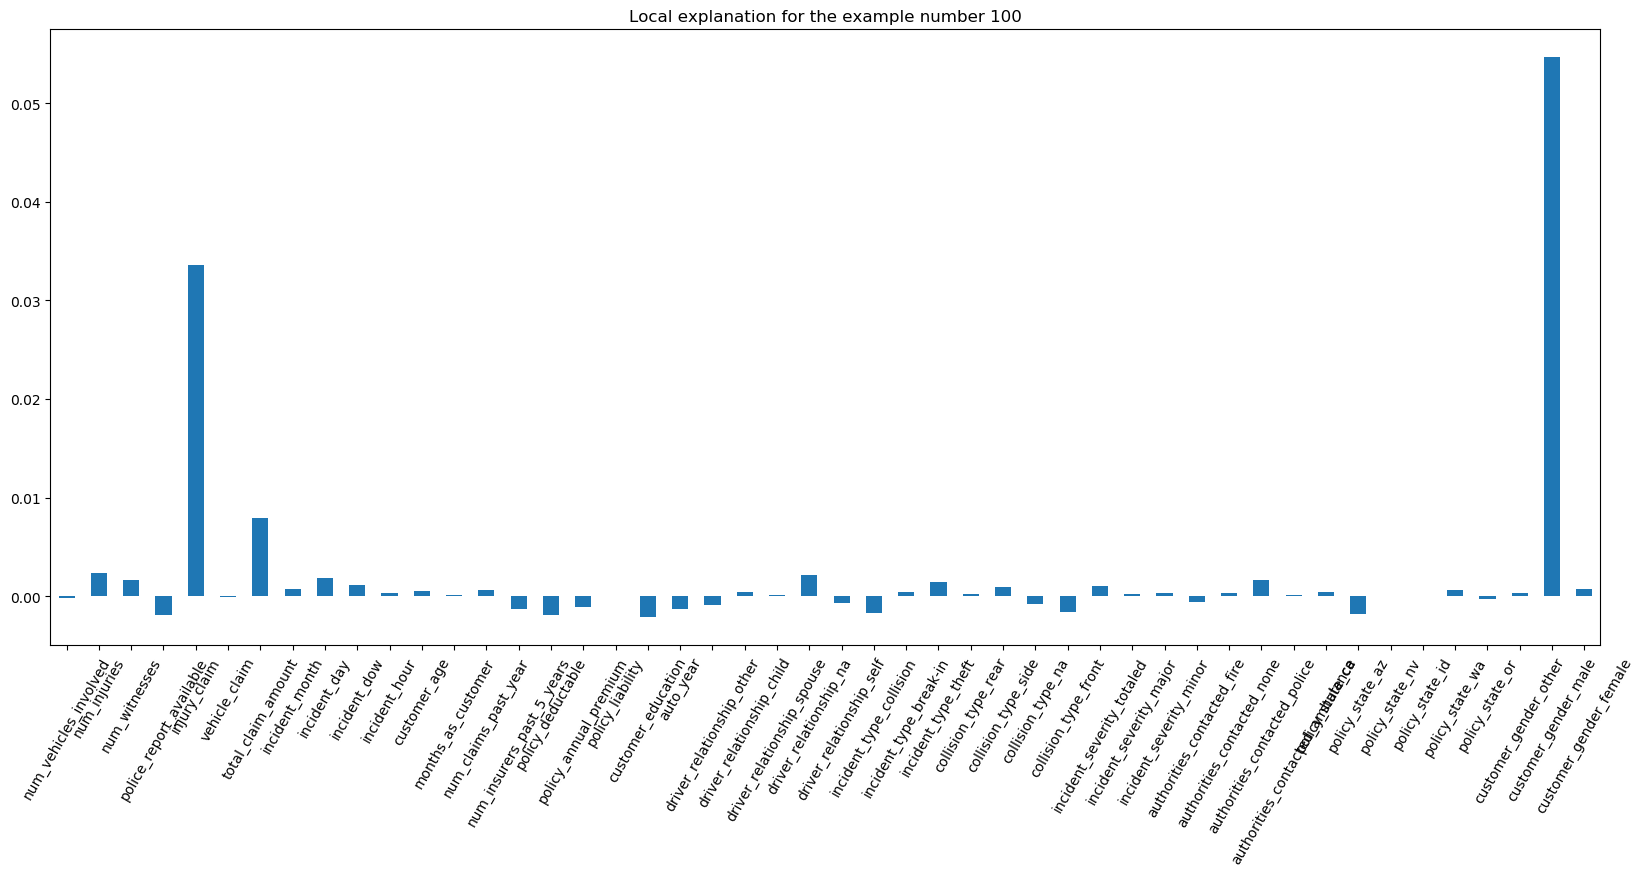

In [21]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
local_explanations_out = pd.read_csv(explainability_report_output_uri + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in 
local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 100
print("Example number:", selected_example)

local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=60, figsize=(20, 8)
);

# Step 5: Deploy the model to a real-time inference endpoint

#### [Note]: ETA - 5 mins.⬇️

In [22]:
best_train_job_name = tuner.best_training_job()

model_path = estimator_output_uri + '/' + best_train_job_name + '/output/model.tar.gz'
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")
create_model_config = {"model_data":model_path,
                       "role":sagemaker_role,
                       "image_uri":training_image,
                       "name":endpoint_name_prefix,
                       "predictor_cls":sagemaker.predictor.Predictor
                       }
# Create a SageMaker model
model = sagemaker.model.Model(**create_model_config)

# Deploy the best model and get access to a SageMaker Predictor
predictor = model.deploy(initial_instance_count=predictor_instance_count, 
                         instance_type=predictor_instance_type,
                         serializer=CSVSerializer(),
                         deserializer=CSVDeserializer())
print(f"\nModel deployed at endpoint : {model.endpoint_name}")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: xgb-fraud-model-dev
INFO:sagemaker:Creating endpoint-config with name xgb-fraud-model-dev-2023-03-05-22-33-49-967
INFO:sagemaker:Creating endpoint with name xgb-fraud-model-dev-2023-03-05-22-33-49-967


-------!
Model deployed at endpoint : xgb-fraud-model-dev-2023-03-05-22-33-49-967


In [26]:
# Sample test data
test_df = pd.read_csv(test_data_uri)
payload = test_df.drop(["fraud"], axis=1).iloc[10].to_list()
print(f"Model predicted score : {float(predictor.predict(payload)[0][0]):.3f}, True label : {test_df['fraud'].iloc[10]}")

Model predicted score : 0.116, True label : 0
